# Bayesian Logistic Regression

Bayesian logistic regression is not much different from classical (frequentist) logistic regression, only that this time we are also endowed with prior distributions over the model parameters $\beta$ which we want to infer. This turns the classical, discriminative logistic regression into a generative model, and yields probability distributions over the regression parameters, instead of point estimates. The following will explain all of this in more detail.

## Frequentist Logistic Regression

In frequentist logistic regression, we start with binary data $\vec{y} = (y_1, y_2, ..., y_n)^T, y_i\in \{0,1\}$. For example, we are interested whether a randomly selected is married ($y=1$) or not ($y=0$). Besides the general ratio of married and unmarried people in our sample, we want to be able to accurately guess whether a person is married, based on some further characteristics $x_1, x_2, ...$. For simplicity, we will only focus on two examplary features, say the age $x_1$ and biological sex $x_2 \in \{0,1\}$ of the person.

Next, we define the model. A logistic regression model looks like this: 

$$p(y=1) = \sigma(z)$$
$$z = \beta_0 + \beta_1+x_1 + \beta_2 x_2.$$

Here, $\sigma(\cdot)$ stands for the sigmoid function. A classical logistic regression model would then infer the regression parameters $\beta_i$ by a least squares algorithm, or by maximum-likelihood estimation.

## Bayesian Logistic Regression

In Bayesian linear regression, we want to extend the concept of the frequentist approach to proabbility distributions, and be able to include prior distributions. The main idea behind any Bayesian inference approach looks like this:

$$\underbrace{p(parameters | data)}_{\text{Posterior}}\propto \underbrace{p(data | parameters)}_{\text{Likelihood}}\cdot \underbrace{p(parameters)}_{\text{Prior}}.$$

Applied to the logistic regression it looks like this:

$$p(\beta_0,\beta_1,\beta_2 | y)\propto p(y | \beta_0,\beta_1,\beta_2)\cdot p(\beta_0,\beta_1,\beta_2).$$

Now, the Likelihood is the probability of observing a given datapoint, given a certain set of regression parameters for that datapoint. We already know that probability, it is:

$$p(y=1) = \sigma(\beta_0 + \beta_1+x_1 + \beta_2 x_2).$$

This is described by the Bernoulli distribution $Bernoulli(p)=p^x(1-p)^x, x\in \{0,1\}$, where $p$ corresponds to $p(y=1)$ from the previous equation. If we assume, for simplicity, a multivariate Gaussian prior for the model parameters, the whole expression for the Bayesian linear regression looks as follows:

$$p(\beta_0,\beta_1,\beta_2 | y)\propto \sigma(\beta_0 + \beta_1+x_1 + \beta_2 x_2)^x(1-\sigma(\beta_0 + \beta_1+x_1 + \beta_2 x_2))^x \cdot \mathcal{N_3}(\vec{\mu}(\vec{\beta}), \vec{\sigma}^2(\vec{\beta})).$$

For the first step of an iterative inference scheme, we would then only need to plug in the first data value $0$ or $1$, which would return the (unnormalized) posterior distribution over the model parameters $\beta_i$.

## Monte Carlo Sampling

One resason why Bayesian approaches to frequentist analysis only became widespread with the advent of advanced computer technology is that they are quite hard to solve. To solve the Bayesian logistic regression above analytically, one would typically need to use the likelihood's [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior), which guarantees that the posterior is of the same form as the prior. This would then return simple equations for the parmeters of the posterior distribution. But what is the correct conjugate prior in the case of the Bayesian logistic regression above? The conjugate for a $Bernoulli(p)$ likelihood with model parameter $p$ is a Beta distribution, but in this case the model parameters are not $p$ but $\beta_0,\beta_1$ and $\beta_2$. Already in such a rather standard case it is not easy to tell what the correct conjugate prior distribution would have to be, and it is not hard to imagine that conjugate priors are all but impossible to determine once models become more complex.

Fortunately, Monte Carlo Sampling does away with the need for conjugate priors, as Markov Chain Monte Carlo algorithms allows us to sample from any distribution as long as we know its y-value at every point. This allows us to sample from any posterior, and determine its parameters from the samples, or approximate it with distributions that seem appropriate. 

Another advantage of MCMC sampling is that we can now choose prior distributions that best fit our previous knowledge about the model parameters, without the need of accomodating any constraints imposed by the form of the conjugate prior.

Below, a logistic linear regression analysis is implemented with PyMC3, which implements such a sampling approach.

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8808513355947747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896467157520438, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'beta2'}>,
        <AxesSubplot:title={'center':'beta2'}>]], dtype=object)

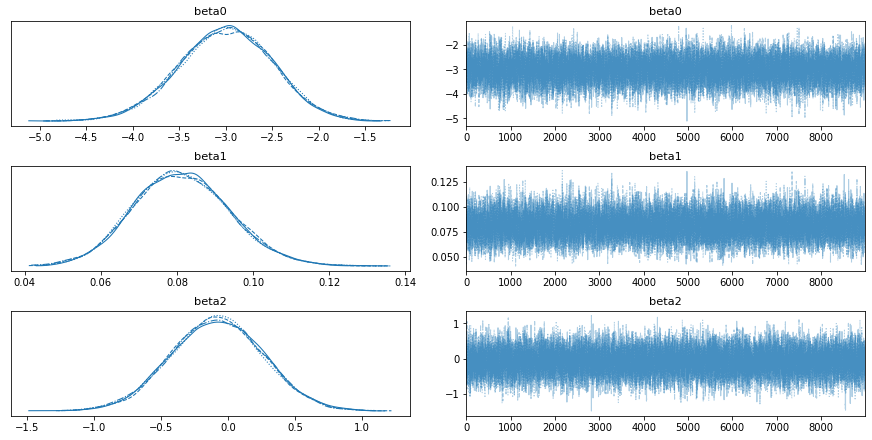

In [60]:
import pymc3 as pm
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

## Simulate random data
# First 100 have low probability of being married, last 100 have high probability
y = np.concatenate((np.random.choice([0,1],p=[0.8, 0.2],size=(100)), np.random.choice([0,1],p=[0.2, 0.8],size=(100))))
# First 100 are aged between 20 and 30, last 100 between 30 and 80
x1 = np.concatenate((np.random.randint(20,31,size=(100)), np.random.randint(30,81,size=(100))))
# Biological sex is randomly distributed
x2 = np.random.randint(2,size=(200))

with pm.Model() as model_0:
    beta0 = pm.Normal('beta0', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    beta2 = pm.Normal('beta2', mu=0, sd=10)

    mu = beta0 + pm.math.dot(x1, beta1) +  pm.math.dot(x2, beta2)

    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))

    yl = pm.Bernoulli('yl', theta, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(10000, step, start)
    chain_0 = trace_0[1000:]

    # Store MAP estimates (= Maximum A Posteriori Estimate = MLE if prior is uniform) for all participants
    # This will later be used to get a group-level estimate of the parameter ranges.

    map_estimate = pm.find_MAP(model=model_0)

varnames = ['beta0', 'beta1', 'beta2']
pm.traceplot(chain_0, varnames)

As expected from the way the da was simulated, the regression parameter $\beta_1$, which is associated with age, is significantly different from zero, while the regression parameter $\beta_2$, associated with sex, is close to zero.

# Discriminative Models vs Generative Models
Mathematically, discriminative models learn the conditional probability distribution $p(y|\theta)$, where $\theta$ stands for the model parameters and $y$ for the observed data. Generative models, on the other hand, learn the joint probability distribution $p(y,\theta)=p(y|\theta)p(\theta)$. This purely mathematical definition may however be hard to interpret, and given a model, some people might have a hard time figuring out whether it is generative or discriminative. The go-to phrase of some often is that ''generative models can generate data, while discriminative models cannot''. But that explanation often only adds more confusion. After obtaining estimates for $\beta_i$ with a classical logistic regression approach, couldn't I simply generate data that would have to be close to the same regression parameters? Yet, the logistic regression model is discriminative.

Comparing the frequentist and the bayesian logistic regressions above might make the difference easier to understand. In the frequentist logistic regression analysis, we only define the likelihood $p(y|\beta_0, \beta_1, \beta_2)=Binomial(\sigma(\beta_0 + x_1\cdot \beta_1 + \cdot \beta_2))$, and then use the parameters $\beta_i$ that maximize that likelihood function (Note that we cannot perform stepwise inference in frequentist analysis, so we have to process the data in batch and therefore use the "multivariate" Bernoulli distribution, the Binomial distribution). 

Such a frequentist approach does however yield no estimate about the distribution of model parameters, which you need in order to generate data. Yes, given a set of regression parameters, it is possible to generate data with similar regression parameters, but it would not be possible to generate data with different regression parameters, where the probability of occurrence is true to the ''real'' distribution of model parameters.